In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split


In [2]:
# prompt: Please like share & subscribe to Techcps https://www.youtube.com/@techcps

project_id = 'qwiklabs-gcp-04-7979f9aa2bcc'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

import pandas as pd
df_customer_stats = bpd.read_gbq(f'{project_id}.{dataset_name}.{table_name}')
df_customer_stats.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,28423,1248,1,69.5
1,28381,982,1,39.5
2,70292,1170,1,9.0
3,37719,954,1,32.950001
4,78568,1256,1,7.44
5,16890,1079,1,119.0
6,9254,1076,1,248.0
7,34444,1015,1,15.99
8,7284,1123,3,19.936666
9,21742,1090,3,106.006667


In [5]:
# prompt: bqdf = client.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
# df.head(10)

df = client.query(f"SELECT * FROM `{project_id}.{dataset_name}.{table_name}`").to_dataframe()
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,89604,892,1,11.050000
1,23302,892,1,129.000000
2,49454,892,1,284.750000
3,74080,892,1,23.950001
4,41700,892,1,14.990000
5,16511,892,1,79.500000
6,78404,892,1,34.000000
7,36680,892,1,25.000000
8,9537,892,1,69.000000
9,6071,892,1,243.000000


In [6]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2025-06-10 05:54:56.090521+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_id,days_since_last_order,count_orders,average_spend
0,28423,1248,1,69.5
1,28381,982,1,39.5
2,70292,1170,1,9.0
3,37719,954,1,32.950001
4,78568,1256,1,7.44
5,16890,1079,1,119.0
6,9254,1076,1,248.0
7,34444,1015,1,15.99
8,7284,1123,3,19.936666
9,21742,1090,3,106.006667


In [7]:
# prompt: #prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.
# df_train, df_test = train_test_split(bq_df, test_siz

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)

kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [8]:
# prompt: # prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.
# predictions_df = kmeans.predict(df_test)
# predictions_df.head(10)

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)


,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.555398070112...",37719,954,1,32.950001
10,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.778658175396...",93128,1089,1,28.0
23,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.483162234857...",58555,1140,4,111.545
24,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.682263322043...",13949,987,1,28.0
27,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.836223870182...",28371,952,2,24.5
30,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.382432678215...",84378,906,1,42.5
31,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.141650220729...",90254,952,1,18.0
50,2,"[{'CENTROID_ID': 2, 'DISTANCE': 0.923370939708...",24427,925,2,66.475
56,1,"[{'CENTROID_ID': 1, 'DISTANCE': 2.011164746479...",81823,1200,4,48.120001
57,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.976005729176...",70805,964,4,64.370001


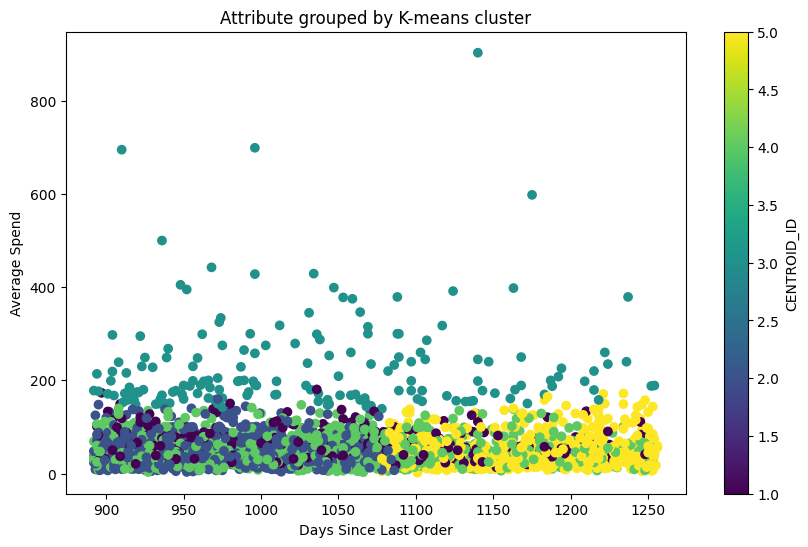

In [9]:
# prompt: #prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."
# import matplotlib.pyplot as plt
# # Create the scatter plot
# plt.figure(figsize=(10, 6))  # Adjust figure s

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()

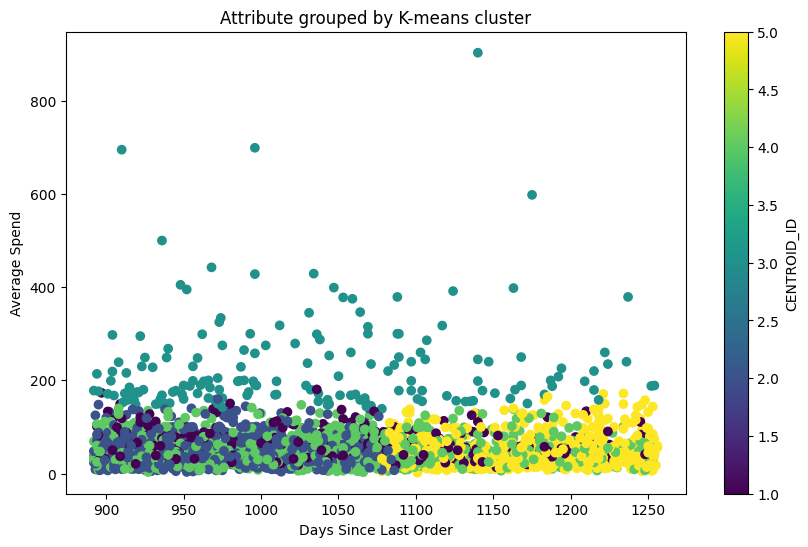

In [10]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()


In [15]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,58.99,3.68,1026.67
1,cluster 2,47.19,1.30,975.17
2,cluster 3,226.64,1.24,1050.56
3,cluster 4,47.09,1.28,1045.97
4,cluster 5,48.94,1.31,1176.54


In [16]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $58.99, count of orders per person 3.68, days since last order 1026.67
cluster 2, average spend $47.19, count of orders per person 1.3, days since last order 975.17
cluster 3, average spend $226.64, count of orders per person 1.24, days since last order 1050.56
cluster 4, average spend $47.09, count of orders per person 1.28, days since last order 1045.97
cluster 5, average spend $48.94, count of orders per person 1.31, days since last order 1176.54


In [18]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [21]:
model = GenerativeModel("gemini-2.0-flash")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

Okay, here's a breakdown of each cluster, a creative title for the persona, a detailed persona description, and a strategic next marketing action, designed to re-engage and reactivate these customers.

**Cluster 1: The Loyal Ghosts**

*   **Title:** "The Nostalgic Navigator"
*   **Persona:** This customer used to be a regular, placing multiple orders (3.68 on average) with a decent average spend ($58.99). They clearly enjoyed the product/service at one point. However, it's been a very long time (1026.67 days) since their last purchase. They likely have fond memories of your brand but have drifted away, possibly due to changing needs, new competitors, or simply forgetting about you. They are likely to respond to nostalgia and reminders of why they loved your brand in the first place.
*   **Next Marketing Step:**
    1.  **Segmentation:** Create a specific segment within your CRM for Cluster 1.
    2.  **Personalized Email Campaign (Nostalgia Focus):**
        *   **Subject Line:** "Reme